# This file generates the Heatmap for the paper

The actual derivation/testing of this model is in exp/exp002_Heatmap

## Data

In [1]:
%matplotlib inline
from tueplots import bundles
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("pdf", "svg")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update(bundles.neurips2021(usetex=False))
import matplotlib
from datetime import datetime

In [2]:
data = pd.read_csv("../dat/SimpleCombinedData.csv", parse_dates=["date"])
data.head()

,date,cases,deaths,cases_smoothed,deaths_smoothed,cfr,air temperature
0,2020-01-02,1.0,0.0,0.142857,0.0,0.0,1.581111
1,2020-01-03,0.0,0.0,0.142857,0.0,0.0,1.974444
2,2020-01-04,0.0,0.0,0.142857,0.0,0.0,2.328684
3,2020-01-05,0.0,0.0,0.142857,0.0,0.0,2.908684
4,2020-01-06,0.0,0.0,0.000000,0.0,0.0,3.061591


In [3]:
def features(date, temp):
    return np.stack(
    (
        date,
        temp,
    ), axis=1
)

In [4]:
X = features(data.index, data["air temperature"])
y = data.cfr.to_numpy()

peak_of_first_wave = np.argmax(y) # see exp001

## Heatmap

In [5]:
time = np.unique(data.date.apply(lambda x: f"{x.year}-{x.month:02d}"))
temp = np.arange(
    data["air temperature"].round().min(),
    data["air temperature"].round().max() + 1
)[::-1]

print(time.shape, temp.shape)

(25,) (34,)


Generate ground truths heatmap by looping over the dataset and making lists of temperatures seen every month, then compute the average. Also make an alpha_map indicating where there are no values

In [6]:
heatmap = [[ [] for _ in time] for _ in temp]
heatmap_alpha = [[ [] for _ in time] for _ in temp]

for t, at, cfr in zip(data.date, data["air temperature"], data.cfr):
    
    date = f"{t.year}-{t.month:02d}"
    j = np.argwhere(time == date)[0,0]
    
    air_temp = np.round(at)
    i = np.argwhere(temp == air_temp)[0,0]
    
    heatmap[i][j].append(cfr)
    
for i in range(len(heatmap)):
    for j in range(len(heatmap[0])):
        if len(heatmap[i][j]) == 0:
            heatmap[i][j] = 0
            heatmap_alpha[i][j] = 0
        else:
            heatmap[i][j] = np.array(heatmap[i][j]).mean()
            heatmap_alpha[i][j] = 1

heatmap = np.array(heatmap)
heatmap_alpha = np.array(heatmap_alpha, dtype=np.float64)

## Plotting

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
def f(X, params):
    time = X[:, 0]
    temp = X[:, 1]
    
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    
    return a * np.exp(b * (time - peak_of_first_wave)) * sigmoid(c * (temp + d))
guess = [0.15, -0.004,  -0.2, -10]

In [9]:
def f_to_latex(params):
    a = f"{params[0]:0.4f}"
    b = f"{params[1]:0.2f}"
    c = f"{params[2]:0.2f}"
    d = f"{params[3]:0.2f}"
    
    return f"{a} \\cdot e^{{ \\frac{{{b}}}{{d}} \\cdot (t - {peak_of_first_wave}d) }} \\cdot  \\sigma \\left(\\frac{{{c}}}{{^\\circ C}} \cdot (\\theta {'+' if float(d) >= 0 else ''} {d}^\\circ C) \\right) \\cdot \\frac{{deaths}}{{cases}}"

In [10]:
from scipy.optimize import minimize

In [11]:
res = minimize(
    lambda params: np.square(y[peak_of_first_wave:] - f(X[peak_of_first_wave:], params)).sum(),
    guess,
    method="Nelder-Mead",
    #method = "BFGS",
    #jac="2-point",
    options={
        "maxiter": 10000
    }
)
params = res.x
res

 final_simplex: (array([[ 0.28713692, -0.00560421, -0.15433518, -2.04878515],
       [ 0.28713645, -0.00560421, -0.15433568, -2.04883358],
       [ 0.28713713, -0.00560422, -0.15433593, -2.04884629],
       [ 0.28713945, -0.00560422, -0.15433505, -2.04871747],
       [ 0.28713846, -0.00560422, -0.15433514, -2.04875974]]), array([0.03096809, 0.03096809, 0.03096809, 0.03096809, 0.03096809]))
           fun: 0.030968086334886027
       message: 'Optimization terminated successfully.'
          nfev: 266
           nit: 154
        status: 0
       success: True
             x: array([ 0.28713692, -0.00560421, -0.15433518, -2.04878515])

In [12]:
print(np.square(f(X[peak_of_first_wave:], params) - y[peak_of_first_wave:]).sum())

0.030968086334886027


In [13]:
custom_model = lambda x: f(x, params)

(0.0, 0.08)

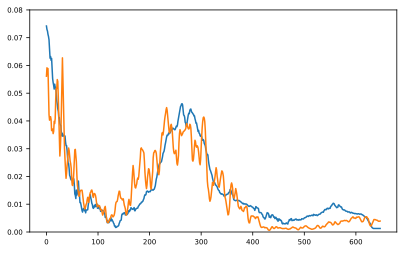

In [14]:
plt.plot(y[peak_of_first_wave:])
y_pred = custom_model(X[peak_of_first_wave:])
plt.plot(y_pred)
plt.ylim([0, 0.08])

In [15]:
months_as_days_since_outbreak = data.date[data.date.apply(lambda x: x.day) == 15]
days = months_as_days_since_outbreak.index
days_grid, temp_grid = np.meshgrid(days, temp)

In [16]:
X_pred = features(days_grid.flatten(), temp_grid.flatten())
y_pred = custom_model(X_pred)

In [17]:
prediction = y_pred.reshape(heatmap.shape)

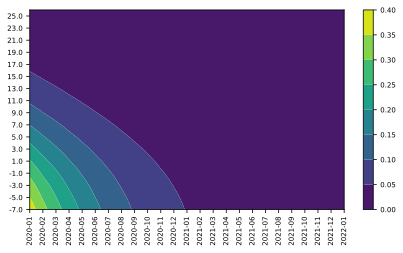

In [18]:
plt.contourf(prediction[::-1])
plt.xticks(np.arange(len(time)), time, rotation=90)
plt.yticks(np.arange(len(temp))[::2], temp[::-2])
plt.colorbar()
plt.show()

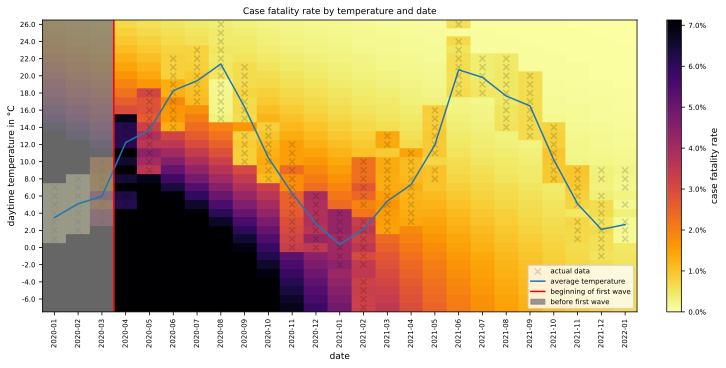

In [19]:
plt.figure(figsize=(10,5))
vmin = heatmap.min()
vmax = heatmap.max()
plt.imshow(prediction, vmin=vmin, vmax=vmax, aspect="auto", cmap="inferno_r")
hm = plt.imshow(heatmap, vmin=vmin, vmax=vmax, aspect="auto", cmap="inferno_r", alpha=heatmap_alpha)

a, b = np.where(heatmap_alpha == 1)
plt.scatter(b, a, marker="x", color="black", alpha=0.15, label="actual data")

plt.xticks(np.arange(len(time)), time, rotation=90)
plt.yticks(np.arange(len(temp))[::2], temp[::2])
beginning = 2.5
plt.plot(
    temp.max() - 
    data["air temperature"]
        .groupby(lambda x: f"{data.iloc[x].date.year}-{data.iloc[x].date.month:02d}")
        .mean(),
    label="average temperature"
)
plt.axvline(beginning, color="red", label="beginning of first wave")
plt.fill(
    [-1, -1, beginning, beginning],
    [-0.5, heatmap.shape[0]-0.5, heatmap.shape[0]-0.5, -0.5],
    color="grey",
    alpha = 0.8,
    label="before first wave"
)
plt.colorbar(hm, format=matplotlib.ticker.PercentFormatter(xmax=1), label="case fatality rate", alpha=1)
plt.legend(loc="lower right")
plt.title("Case fatality rate by temperature and date")
plt.xlabel("date")
plt.xlim(-0.5)
plt.ylabel("daytime temperature in °C")
plt.savefig("../fig/heatmap.pdf")
plt.show()

In [20]:
print(f_to_latex(params))

0.2871 \cdot e^{ \frac{-0.01}{d} \cdot (t - 101d) } \cdot  \sigma \left(\frac{-0.15}{^\circ C} \cdot (\theta  -2.05^\circ C) \right) \cdot \frac{deaths}{cases}


Final formula
$$
0.2871 \cdot e^{ \frac{-0.01}{d} \cdot (t - 101d) } \cdot  \sigma \left(\frac{-0.15}{^\circ C} \cdot (\theta  -2.05^\circ C) \right) \cdot \frac{deaths}{cases}
$$

In [21]:
with open("../doc/formula.tex", "w") as f:
    f.write(f_to_latex(params))